In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "/content/drive/MyDrive/ML"

 abbreviations.xlsx	       tokenizer.pkl		       word2vec_sentiment.model
'Data_ML(preprocessed).xlsx'  'vietnamese-stopwords (1).txt'


In [4]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from joblib import dump, load
import ast
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [11]:
data =pd.read_excel('/content/drive/MyDrive/ML/Data_ML(preprocessed).xlsx', engine='openpyxl')
# Kiểm tra giá trị unique trong cột SERVICE
print("Các giá trị trong cột SERVICE:", data['SERVICE'].unique())

Các giá trị trong cột SERVICE: ['neutral' 'positive' 'negative']


In [12]:
# Tách tập train/test
train_comments, test_comments, train_labels, test_labels = train_test_split(
    data['cleaned_content'], data['SERVICE'], test_size=0.2, random_state=42)
# Chuyển đổi mỗi chuỗi thành danh sách thực
train_comments = train_comments.apply(lambda x: ast.literal_eval(x))
test_comments = test_comments.apply(lambda x: ast.literal_eval(x))
print(type(train_comments.iloc[0]))  # Kiểm tra kiểu dữ liệu phần tử đầu tiên
print(data['SERVICE'].value_counts())

<class 'list'>
SERVICE
neutral     6856
positive     518
negative     501
Name: count, dtype: int64


In [13]:
# Chuyển nhãn cảm xúc thành số
label_mapping = {"positive": 2, "negative": 0, "neutral": 1}
train_labels = np.array([label_mapping[label] for label in train_labels])
test_labels = np.array([label_mapping[label] for label in test_labels])

# Tạo tokenizer cho padded sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_comments)

# Lưu tokenizer
#dump(tokenizer, '/content/drive/MyDrive/Final ML/tokenizer.pkl')

word_index = tokenizer.word_index
print(word_index)

# Chuyển dữ liệu thành padded sequences
max_length = 100
train_sequences = tokenizer.texts_to_sequences(train_comments)
test_sequences = tokenizer.texts_to_sequences(test_comments)
print(train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Chuyển nhãn thành dạng one-hot vector cho Neural Network
train_labels_one_hot = to_categorical(train_labels, num_classes=3)
test_labels_one_hot = to_categorical(test_labels, num_classes=3)

{'da': 1, 'sản_phẩm': 2, 'tốt': 3, 'xài': 4, 'mụn': 5, 'mua': 6, 'sử_dụng': 7, 'hàng': 8, 'mặt': 9, 'ẩm': 10, 'hơi': 11, 'dầu': 12, 'nhanh': 13, 'mùi': 14, 'sạch': 15, 'giao': 16, 'khô': 17, 'kem': 18, 'thích': 19, 'ok': 20, 'lắm': 21, 'nhẹ': 22, 'chai': 23, 'rửa': 24, 'tẩy_trang': 25, 'dưỡng': 26, 'ổn': 27, 'nha': 28, 'xong': 29, 'đẹp': 30, 'hiệu_quả': 31, 'giá': 32, 'đóng_gói': 33, 'chống': 34, 'nắng': 35, 'mịn': 36, 'giá_cả': 37, 'dịu': 38, 'hợp_lý': 39, 'da_dầu': 40, 'bao_bì': 41, 'cải_thiện': 42, 'chắc_chắn': 43, 'chậm': 44, 'thấm': 45, 'đắt': 46, 'dễ_chịu': 47, 'sữa': 48, 'mát': 49, 'tẩy': 50, 'hợp': 51, 'hasaki': 52, 'thử': 53, 'rẻ': 54, 'kiềm': 55, 'cảm_giác': 56, 'thơm': 57, 'chất_lượng': 58, 'nhạy_cảm': 59, 'đắp': 60, 'nâng': 61, 'căng': 62, 'thoa': 63, 'kích_ứng': 64, 'đầu': 65, 'bôi': 66, 'mấy': 67, 'màu': 68, 'siêu': 69, 'lớp': 70, 'thoải_mái': 71, 'dễ_dàng': 72, 'trắng': 73, 'hương': 74, 'shop': 75, 'giá_thành': 76, 'tone': 77, 'nhờn': 78, 'tặng': 79, 'giãn': 80, 'cực': 8

In [14]:
# Huấn luyện Word2Vec
processed_train_comments = [comment for comment in train_comments]
print(processed_train_comments)
w2v_model = Word2Vec(sentences=processed_train_comments, vector_size=100, window=3, min_count=1, workers=4)
# Lưu mô hình Word2Vec
#w2v_model.save('/content/drive/MyDrive/Final ML/word2vec_sentiment.model')

# Hàm chuyển đổi dữ liệu sang vector đặc trưng bằng Word2Vec
def vectorize_comment(comment, model, vector_dim):
    words = comment
    word_vectors = [model.wv[word] for word in words if word in list(w2v_model.wv.index_to_key)]
    if len(word_vectors) == 0:
        return np.zeros(vector_dim)  # Nếu không có từ nào trong mô hình Word2Vec
    return np.mean(word_vectors, axis=0)

# Tạo vector đặc trưng
vector_dim = 100
train_vectors = np.array([vectorize_comment(comment, w2v_model, vector_dim) for comment in train_comments])
test_vectors = np.array([vectorize_comment(comment, w2v_model, vector_dim) for comment in test_comments])


[['săn', 'giá', 'hời', 'sàn', 'tiktokshop', 'shopeelazada', 'mãi', 'ủng_hộ', 'chương_trình', 'sale', 'hasaki', 'sản_phẩm', 'hãng'], ['tốt', 'dị_ứng', 'da', 'sách', 'da'], ['sản_phẩm', 'tốt', 'lắm', 'nha', 'giao', 'nhanh', 'shiper', 'dễ_thương', 'lắm'], ['sữa', 'rửa', 'mặt', 'thời_gian', 'bớt', 'mụn', 'chữ', 't', 'bình_thường', 'đổ', 'dầu', 'mụn', 'cải_thiện', 'rõ_rệt', 'í'], ['toner', 'dưỡng', 'ẩm', 'tốt', 'mùi', 'thơm', 'dễ_chịu'], ['chất_lượng', 'test', 'thử'], ['xài', 'ổn', 'da_dầu', 'mụn', 'hơi', 'nhạy_cảm', 'dần', 'không_thể', 'chấp_nhận', 'mùi', 'mùi', 'xà_phòng', 'tẩy_trang', 'hãng', 'tưởng', 'xà_phòng', 'đi', 'tẩy_trang', 'mua', 'mùi', 'hương'], ['sản_phẩm', 'tốt'], ['okk', 'nha'], ['hàng', 'sử_dụng', 'ok', 'chất', 'đặc'], ['mua', 'xài', 'tầm', 'tuần', 'uổn', 'tự_dưng', 'đen', 'xì', 'lì', 'xác_định', 'xài', 'kem', 'dưỡng', 'căng', 'mướt_thui', 'củng', 'kg', 'mong', 'trắng', 'cơ_bản', 'da', 'trắng', 'sẳng', 'mặt', 'đen_thui'], ['omg', 'nói_chung', 'dòng', 'ttcủa', 'laneige', 'mê

In [15]:
# Hàm huấn luyện Neural Network
def train_neural_network(X_train_fold, y_train_fold, X_valid_fold, y_valid_fold, embedding_matrix, word_index, vector_dim):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=vector_dim,
                        weights=[embedding_matrix], trainable=True))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train_fold, y_train_fold,
              validation_data=(X_valid_fold, y_valid_fold),
              epochs=15, batch_size=64, verbose=0, callbacks=[early_stopping])
    return model
# Chuẩn bị embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, vector_dim))
for word, i in word_index.items():
    if word in list(w2v_model.wv.index_to_key):
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix)

#Đánh giá mô hình Neural Network
def evaluate_model(model, X_valid_fold, y_valid_fold):
    _, nn_accuracy = model.evaluate(X_valid_fold, y_valid_fold, verbose=0)
    return nn_accuracy * 100


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.04470399  0.32197803  0.12109278 ... -0.20524462  0.24941003
   0.36441386]
 [-0.40981883  0.47306162 -0.10578995 ... -0.32951406 -0.3330932
  -0.43797603]
 ...
 [-0.00294111  0.01039918  0.00431253 ... -0.00713765  0.01228198
  -0.00852479]
 [-0.00121442  0.00395251  0.00508704 ... -0.00090422  0.00285101
   0.00163242]
 [-0.00159631  0.00755568  0.00486004 ...  0.00367042  0.00437833
  -0.00056223]]


In [18]:
# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lưu kết quả
results = {
    "Fold": [],
    "Logistic Regression": [],
    "SVM": [],
    "Random Forest": [],
    "Neural Network": []
}

fold_index = 1
for train_index, valid_index in kf.split(train_vectors):
    # Dữ liệu cho các mô hình ngoài Neural Network
    X_train_fold, X_valid_fold = train_vectors[train_index], train_vectors[valid_index]
    y_train_fold, y_valid_fold = train_labels[train_index], train_labels[valid_index]

    # Dữ liệu cho Neural Network
    X_train_padded_fold, X_valid_padded_fold = train_padded[train_index], train_padded[valid_index]
    y_train_one_hot_fold, y_valid_one_hot_fold = train_labels_one_hot[train_index], train_labels_one_hot[valid_index]

    # Logistic Regression
    log_reg = LogisticRegression(max_iter=300)
    log_reg.fit(X_train_fold, y_train_fold)
    log_reg_pred = log_reg.predict(X_valid_fold)
    log_reg_accuracy = accuracy_score(y_valid_fold, log_reg_pred) * 100

    # SVM
    svm = SVC(kernel='rbf',gamma=0.05, probability=True)
    svm.fit(X_train_fold, y_train_fold)
    svm_pred = svm.predict(X_valid_fold)
    svm_accuracy = accuracy_score(y_valid_fold, svm_pred) * 100

    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train_fold, y_train_fold)
    rf_pred = rf.predict(X_valid_fold)
    rf_accuracy = accuracy_score(y_valid_fold, rf_pred) * 100

    # Neural Network
    nn_model = train_neural_network(X_train_padded_fold, y_train_one_hot_fold, X_valid_padded_fold, y_valid_one_hot_fold, embedding_matrix
                                    , word_index, vector_dim)
    nn_accuracy = evaluate_model(nn_model, X_valid_padded_fold, y_valid_one_hot_fold)

    # Lưu kết quả
    results["Fold"].append(fold_index)
    results["Logistic Regression"].append(round(log_reg_accuracy, 2))
    results["SVM"].append(round(svm_accuracy, 2))
    results["Random Forest"].append(round(rf_accuracy, 2))
    results["Neural Network"].append(round(nn_accuracy, 2))

    print(f"Fold {fold_index}:")
    print(f"Logistic Regression Accuracy: {log_reg_accuracy:.2f}%")
    print(f"SVM Accuracy: {svm_accuracy:.2f}%")
    print(f"Random Forest Accuracy: {rf_accuracy:.2f}%")
    print(f"Neural Network Accuracy: {nn_accuracy:.2f}%")
    print("-" * 50)
    fold_index += 1

# Tạo DataFrame kết quả
results_df = pd.DataFrame(results)
print("\nKết quả phân loại với K-Fold Cross-Validation:")
print(results_df)


Fold 1:
Logistic Regression Accuracy: 94.13%
SVM Accuracy: 93.57%
Random Forest Accuracy: 96.67%
Neural Network Accuracy: 97.06%
--------------------------------------------------
Fold 2:
Logistic Regression Accuracy: 94.29%
SVM Accuracy: 94.05%
Random Forest Accuracy: 97.46%
Neural Network Accuracy: 97.94%
--------------------------------------------------
Fold 3:
Logistic Regression Accuracy: 94.52%
SVM Accuracy: 94.76%
Random Forest Accuracy: 97.78%
Neural Network Accuracy: 97.22%
--------------------------------------------------
Fold 4:
Logistic Regression Accuracy: 93.33%
SVM Accuracy: 93.02%
Random Forest Accuracy: 96.51%
Neural Network Accuracy: 96.75%
--------------------------------------------------
Fold 5:
Logistic Regression Accuracy: 95.24%
SVM Accuracy: 94.84%
Random Forest Accuracy: 96.83%
Neural Network Accuracy: 97.14%
--------------------------------------------------

Kết quả phân loại với K-Fold Cross-Validation:
   Fold  Logistic Regression    SVM  Random Forest  

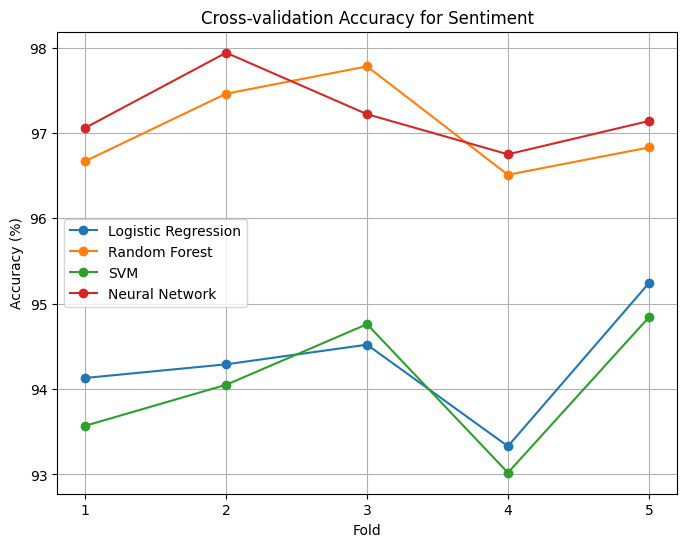

In [19]:
# Lấy thông tin từ DataFrame results
sentiment_fold = results["Fold"]
sentiment_lr_accuracy = results["Logistic Regression"]
sentiment_svm_accuracy = results["SVM"]
sentiment_rf_accuracy = results["Random Forest"]
sentiment_nn_accuracy = results["Neural Network"]

# Vẽ plot cho sentiment
plt.figure(figsize=(8, 6))
plt.plot(results["Fold"], results["Logistic Regression"], marker='o', label='Logistic Regression')
plt.plot(results["Fold"], results["Random Forest"], marker='o', label='Random Forest')
plt.plot(results["Fold"], results["SVM"], marker='o', label='SVM')
plt.plot(results["Fold"], results["Neural Network"], marker='o', label='Neural Network')
plt.title('Cross-validation Accuracy for Sentiment')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(results["Fold"])
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Tính giá trị trung bình của mỗi mô hình và tìm mô hình tốt nhất
models = ["Logistic Regression", "Random Forest", "SVM", "Neural Network"]

# Tạo DataFrame gọn gàng hơn
sentiment_mean_accuracy_df = pd.DataFrame({
    "Model Name": models,
    "Mean_Accuracy": [round(pd.Series(results[model]).mean(), 2) for model in models]
})

# Tìm mô hình có độ chính xác trung bình cao nhất
best_model = sentiment_mean_accuracy_df.loc[sentiment_mean_accuracy_df['Mean_Accuracy'].idxmax()]

# In kết quả
print("Mean_Accuracy for sentiment:")
print(sentiment_mean_accuracy_df)
print(f"\nThe best model is '{best_model['Model Name']}' with a mean accuracy of {best_model['Mean_Accuracy']:.2f}.")


Mean_Accuracy for sentiment:
            Model Name  Mean_Accuracy
0  Logistic Regression          94.30
1        Random Forest          97.05
2                  SVM          94.05
3       Neural Network          97.22

The best model is 'Neural Network' with a mean accuracy of 97.22.


In [21]:
# Dự đoán trên tập test
best_model= train_neural_network(train_padded, train_labels_one_hot, test_padded, test_labels_one_hot, embedding_matrix
                                    , word_index, vector_dim)
best_model_accuracy = evaluate_model(best_model, test_padded, test_labels_one_hot)
print(f"Neural Network Test Accuracy: {best_model_accuracy:.2f}%")

Neural Network Test Accuracy: 97.78%


In [ ]:
# Dự đoán trên tập test
best_model= RandomForestClassifier(n_estimators=100,random_state=42)
best_model.fit(train_vectors, train_labels)
best_model_pred = best_model.predict(test_vectors)
best_model_accuracy = accuracy_score(test_labels, best_model_pred) * 100
print(f"Random Forest Test Accuracy: {best_model_accuracy:.2f}%")

Random Forest Test Accuracy: 86.79%


Vẽ NN

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.99      0.83      0.90       100
     neutral       0.99      1.00      0.99      1374
    positive       0.86      0.88      0.87       101

    accuracy                           0.98      1575
   macro avg       0.95      0.90      0.92      1575
weighted avg       0.98      0.98      0.98      1575



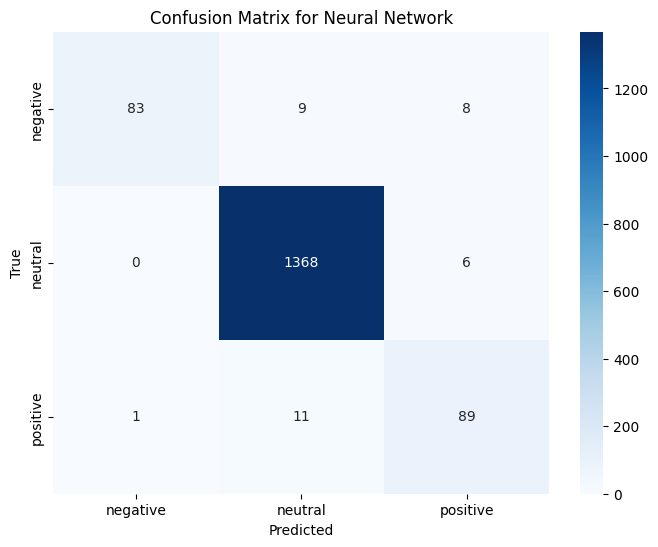

In [22]:
# Dự đoán xác suất
best_model_pred = best_model.predict(test_padded)

# Chuyển sang nhãn dự đoán (class labels)
predicted_labels = np.argmax(best_model_pred, axis=1)
# Chuyển nhãn thực từ one-hot encoding sang class labels
true_labels = np.argmax(test_labels_one_hot, axis=1)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['negative', 'neutral', 'positive'])
print("\nClassification Report:")
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Vẽ RF


Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.55      0.66       185
     neutral       0.85      0.77      0.81       310
    positive       0.88      0.95      0.91      1080

    accuracy                           0.87      1575
   macro avg       0.86      0.76      0.79      1575
weighted avg       0.87      0.87      0.86      1575



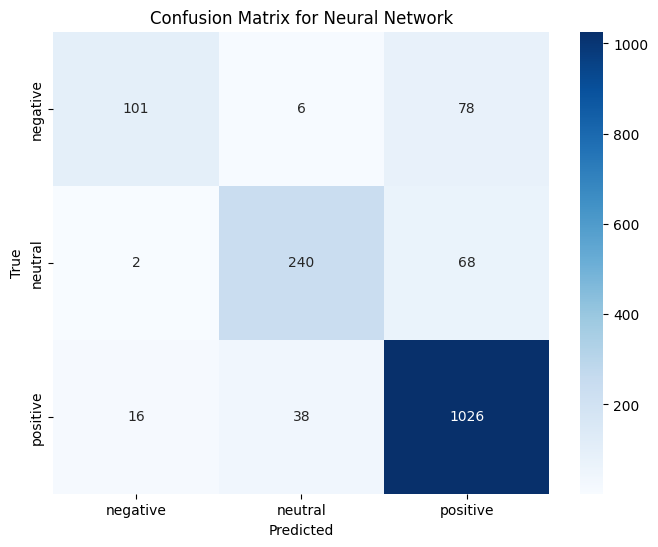

In [ ]:
# 2. Classification Report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(test_labels, best_model_pred, target_names=['negative', 'neutral', 'positive']))

# 3. Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, best_model_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Vẽ NN

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


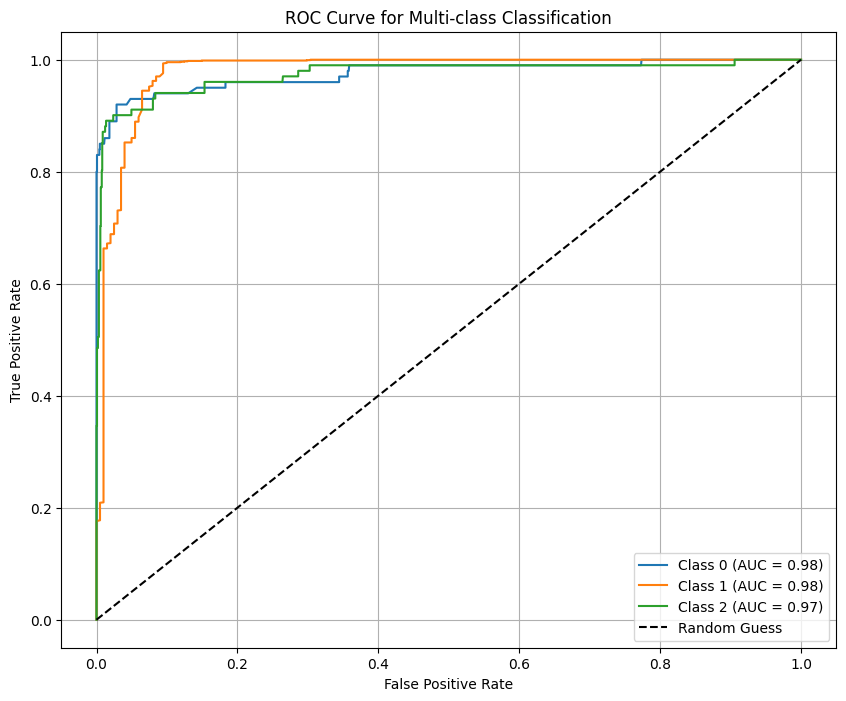

In [23]:
# Dự đoán xác suất cho tập test
probs = best_model.predict(test_padded)

# Chuyển nhãn thực về dạng one-vs-all
true_labels = np.argmax(test_labels_one_hot, axis=1)  # Nhãn thực

# Số lượng lớp
num_classes = test_labels_one_hot.shape[1]

# Vẽ đường cong ROC cho từng lớp
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    # Nhãn thực dạng one-vs-all cho lớp i
    true_binary = (true_labels == i).astype(int)

    # Tính ROC và AUC
    fpr, tpr, _ = roc_curve(true_binary, probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Đường chéo (baseline)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Tùy chỉnh biểu đồ
plt.title("ROC Curve for Multi-class Classification")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


Vẽ RF

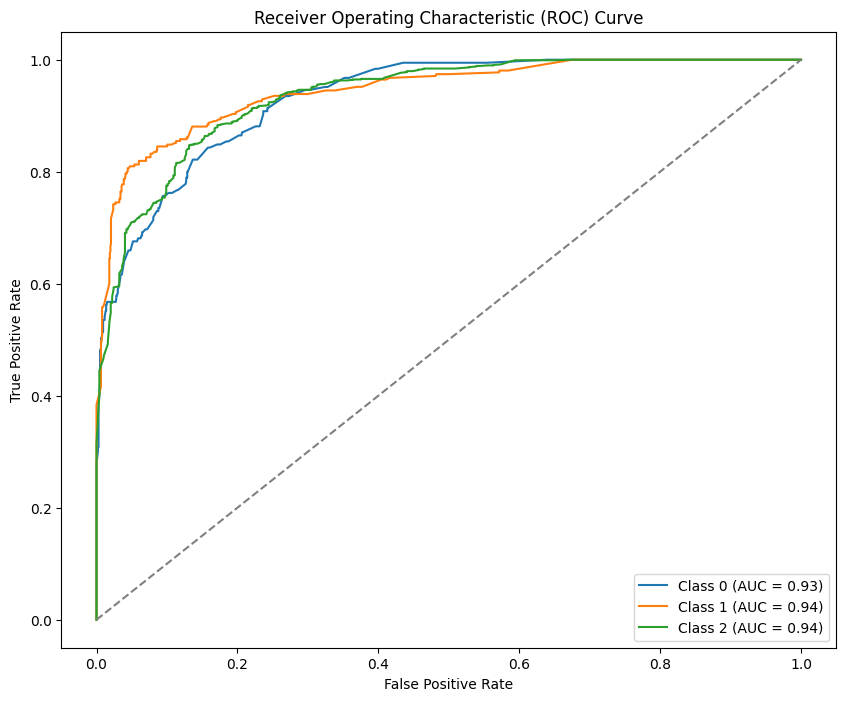

In [ ]:
# 4. Vẽ đường cong ROC và tính chỉ số AUC cho cả 3 lớp
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Dự đoán xác suất cho từng lớp
test_prob = best_model.predict_proba(test_vectors)  # Dự đoán xác suất, không phải nhãn

# Binarize nhãn thực tế
test_labels_binarized = label_binarize(test_labels, classes=[0, 1, 2])

# Tính đường cong ROC và AUC cho từng lớp
fpr, tpr, thresholds = {}, {}, {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], thresholds[i] = roc_curve(test_labels_binarized[:, i], test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Vẽ đường cong ROC
plt.figure(figsize=(10, 8))

for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Lưu mô hình tốt nhất
dump(best_model, '/content/drive/MyDrive/ML/SERVICE_MODEL.joblib')

print(f"Mô hình đã được lưu!")


Mô hình đã được lưu!


RF

In [ ]:
import re
#!pip install pyvi
from pyvi import ViTokenizer
#!pip install emoji
import emoji
# Load các thành phần đã lưu
SERVICE_model = load('/content/drive/MyDrive/Final ML/SERVICE_MODEL.joblib')
w2v_model = Word2Vec.load('/content/drive/MyDrive/Final ML/word2vec_sentiment.model')

# Tiền xử lý
def preprocess_text(text, abbreviation_dict, stopwords):
    # Kiểm tra nếu input không phải là chuỗi, trả về chuỗi rỗng
    if not isinstance(text, str):
        return ""
    # 1. Chuyển về chữ thường
    text = text.lower()
    # 2. Giải mã chữ viết tắt
    for abbreviation, meaning in abbreviation_dict.items():
        text = re.sub(r'\b' + re.escape(abbreviation) + r'\b', meaning, text)
    # 3. Chuyển biểu tượng cảm xúc thành văn bản
    text = emoji.demojize(text)
    # 4. Loại bỏ ký tự đặc biệt
    text = re.sub(r"[!@#$[]()]", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    # 5. Tách từ và loại bỏ stopwords
    tokenized_text = ViTokenizer.tokenize(text)
    tokens = [word for word in tokenized_text.split() if word not in stopwords]
    # 6. Trả về danh sách các từ đã xử lý
    return tokens

# Đọc danh sách chữ viết tắt
abbreviation_path = "/content/drive/MyDrive/Final ML/abbreviations.xlsx"
abbs_df = pd.read_excel(abbreviation_path, engine='openpyxl')
abbreviation_dict = dict(zip(abbs_df['abbreviation'].astype(str), abbs_df['meaning']))

# Đọc danh sách stopwords
stopwords_path = "/content/drive/MyDrive/Final ML/vietnamese-stopwords (1).txt"
with open(stopwords_path, "r", encoding="utf-8") as f:
    stopwords = f.read().split("\n")

# Hàm chuyển đổi dữ liệu sang vector đặc trưng bằng Word2Vec
def vectorize_comment(comment, model, vector_dim):
    words = comment
    word_vectors = [model.wv[word] for word in words if word in list(w2v_model.wv.index_to_key)]
    if len(word_vectors) == 0:
        return np.zeros(vector_dim)  # Nếu không có từ nào trong mô hình Word2Vec
    return np.mean(word_vectors, axis=0)


# Pipeline dự đoán
def predict_sentiment(input_text):
    processed_text = preprocess_text(input_text,abbreviation_dict, stopwords)
    input_vector = vectorize_comment(processed_text, w2v_model, vector_dim=150)
    prediction = SERVICE_model.predict([input_vector])[0]  # Dự đoán nhãn
    return reverse_label_mapping[prediction]

# Mapping nhãn
label_mapping = {"positive": 2, "neutral": 1, "negative": 0}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
# Ví dụ
input_text = "mụn nổi"
# Create a DataFrame with the standardlized_content
data = pd.DataFrame({'cleaned_text': [input_text]}) # Create a DataFrame
# Loại bỏ chỉ mục hiện tại và thay thế bằng chỉ mục mới
data.reset_index(drop=True, inplace=True)
# Lặp qua từng dòng trong DataFrame và in kết quả theo yêu cầu
for index, row in data.iterrows():
    print(f"Văn bản trước tiền xử lý: {row['cleaned_text']}")

    # Áp dụng tiền xử lý
    processed_text = preprocess_text(row['cleaned_text'], abbreviation_dict, stopwords)

    # In kết quả sau tiền xử lý (dạng danh sách)
    print(f"Văn bản đã tiền xử lý: {processed_text}")

predicted_label = predict_sentiment(input_text)
print(f"Input: {input_text}")
print(f"Predicted Sentiment: {predicted_label}")

Văn bản trước tiền xử lý: mụn nổi
Văn bản đã tiền xử lý: ['mụn', 'nổi']
Input: mụn nổi
Predicted Sentiment: negative


NN

In [48]:
import re
#!pip install pyvi
from pyvi import ViTokenizer
#!pip install emoji
import emoji
# Load các thành phần đã lưu
SERVICE_model = load('/content/drive/MyDrive/ML/SERVICE_MODEL.joblib')
w2v_model = Word2Vec.load('/content/drive/MyDrive/ML/word2vec_sentiment.model')
# Tải lại tokenizer
tokenizer_load = load('/content/drive/MyDrive/ML/tokenizer.pkl')

# Tiền xử lý
def preprocess_text(text, abbreviation_dict, stopwords):
    # Kiểm tra nếu input không phải là chuỗi, trả về chuỗi rỗng
    if not isinstance(text, str):
        return ""
    # 1. Chuyển về chữ thường
    text = text.lower()
    # 2. Giải mã chữ viết tắt
    for abbreviation, meaning in abbreviation_dict.items():
        text = re.sub(r'\b' + re.escape(abbreviation) + r'\b', meaning, text)
    # 3. Chuyển biểu tượng cảm xúc thành văn bản
    text = emoji.demojize(text)
    # 4. Loại bỏ ký tự đặc biệt
    text = re.sub(r"[!@#$[]()]", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    # 5. Tách từ và loại bỏ stopwords
    tokenized_text = ViTokenizer.tokenize(text)
    tokens = [word for word in tokenized_text.split() if word not in stopwords]
    # 6. Trả về danh sách các từ đã xử lý
    return tokens

# Đọc danh sách chữ viết tắt
abbreviation_path = "/content/drive/MyDrive/ML/abbreviations.xlsx"
abbs_df = pd.read_excel(abbreviation_path, engine='openpyxl')
abbreviation_dict = dict(zip(abbs_df['abbreviation'].astype(str), abbs_df['meaning']))

# Đọc danh sách stopwords
stopwords_path = "/content/drive/MyDrive/ML/vietnamese-stopwords (1).txt"
with open(stopwords_path, "r", encoding="utf-8") as f:
    stopwords = f.read().split("\n")

# Hàm chuyển đổi dữ liệu sang vector đặc trưng bằng Word2Vec
def vectorize_comment(comment, model, vector_dim):
    words = comment
    word_vectors = [model.wv[word] for word in words if word in list(w2v_model.wv.index_to_key)]
    if len(word_vectors) == 0:
        return np.zeros(vector_dim)  # Nếu không có từ nào trong mô hình Word2Vec
    return np.mean(word_vectors, axis=0)


# Pipeline dự đoán
def predict_sentiment(input_text):
    # Tiền xử lý văn bản
    processed_text = preprocess_text(input_text, abbreviation_dict, stopwords)
    # Ghép các từ đã token hóa thành một chuỗi duy nhất
    processed_text_joined = " ".join(processed_text)
    # Chuyển đổi sang chuỗi số bằng tokenizer
    new_sequences = tokenizer_load.texts_to_sequences([processed_text_joined])  # Đảm bảo đầu vào là danh sách chuỗi
    # Chuyển dữ liệu thành padded sequences
    max_length = 100
    new_padded = pad_sequences(new_sequences, maxlen=max_length, padding='post', truncating='post')
    # Dự đoán nhãn
    prediction = SERVICE_model.predict(new_padded)  # Trả về xác suất
    predicted_label = np.argmax(prediction)  # Lấy nhãn có xác suất cao nhất
    return reverse_label_mapping[predicted_label]


# Mapping nhãn
label_mapping = {"positive": 2, "neutral": 1, "negative": 0}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
# Ví dụ
input_text = "Hiệu quả dưỡng ẩm rất tốt, a Shop tận tình, Giá cả hợp lý Giao hàng chậm, cần cải thiện Bao bì chắc chắn "
# Create a DataFrame
data = pd.DataFrame({'cleaned_text': [input_text]})
# Loại bỏ chỉ mục hiện tại và thay thế bằng chỉ mục mới
data.reset_index(drop=True, inplace=True)
# Lặp qua từng dòng trong DataFrame và in kết quả theo yêu cầu
for index, row in data.iterrows():
    print(f"Văn bản trước tiền xử lý: {row['cleaned_text']}")

    # Áp dụng tiền xử lý
    processed_text = preprocess_text(row['cleaned_text'], abbreviation_dict, stopwords)

    # In kết quả sau tiền xử lý (dạng danh sách)
    print(f"Văn bản đã tiền xử lý: {processed_text}")

predicted_label = predict_sentiment(input_text)
print(f"Input: {input_text}")
print(f"Predicted Sentiment: {predicted_label}")

Văn bản trước tiền xử lý: Hiệu quả dưỡng ẩm rất tốt, a Shop tận tình,  Giao hàng chậm, cần cải thiện Bao bì chắc chắn 
Văn bản đã tiền xử lý: ['hiệu_quả', 'dưỡng', 'ẩm', 'tốt', 'a', 'shop', 'tận_tình', 'giao', 'hàng', 'chậm', 'cải_thiện', 'bao_bì', 'chắc_chắn']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Input: Hiệu quả dưỡng ẩm rất tốt, a Shop tận tình,  Giao hàng chậm, cần cải thiện Bao bì chắc chắn 
Predicted Sentiment: positive
